In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
#pasta = 
holidays_events = pd.read_csv(r'c:\Users\Thyana De Lara\Documents\TCC\modelo_vendas_forecasting\Bases\holidays_events.csv')
train = pd.read_csv(r'c:\Users\Thyana De Lara\Documents\TCC\modelo_vendas_forecasting\Bases\train.csv')
stores = pd.read_csv(r'C:\Users\Thyana De Lara\Documents\TCC\modelo_vendas_forecasting\Bases\stores.csv')

# Informações Basicas

In [26]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [27]:
train['date'] = pd.to_datetime(train['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
 
train_start = train.date.min().date()
train_end = train.date.max().date()

print("="*25)
print("Informações Básicas da Base de Dados")
print("="*25)

print(f"Número de tipos de produtos      : {train.family.nunique()}")
print(f"Número de lojas            : {train.store_nbr.nunique()}")
print(f"Número de produto           : {train.id.nunique()}")
print(f"Número de combinações Loja + Família: {train.groupby(["store_nbr", "family"]).ngroups}")
print(f"Número de séries temporais (targets)        : {train.groupby(["store_nbr", "family"]).ngroups}\n")

print(f"Número de datas únicas no treino: {train.date.nunique()}")
print(f"Período do treino             : {(train_end - train_start).days + 1} dias - de  {train.date.min().date()} até {train.date.max().date()}")


Informações Básicas da Base de Dados
Número de tipos de produtos      : 33
Número de lojas            : 54
Número de produto           : 3000888
Número de combinações Loja + Família: 1782
Número de séries temporais (targets)        : 1782

Número de datas únicas no treino: 1684
Período do treino             : 1688 dias - de  2013-01-01 até 2017-08-15


In [28]:
print(f"Total de linhas antes filtro: {len(train)}")
print(f"Custo total: {train['sales'].sum():,.2f}")
print(f"Promoções total: {train['onpromotion'].sum():,.2f}")

Total de linhas antes filtro: 3000888
Custo total: 1,073,644,952.20
Promoções total: 7,810,622.00


In [29]:
print("\nInformações do DataFrame:")
print(train.info())
print("\nContagem de valores nulos por coluna:")
print(train.isnull().sum())


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None

Contagem de valores nulos por coluna:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [30]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

# Criação do campo de frequência

A variável dias_ativos_venda foi criada a partir da contagem do número de dias, a combinação de loja e família de produto apresentou registros de venda dentro de cada mês. Essa métrica representa a frequência com que houve movimentação comercial para aquele item no mês, servindo como indicador complementar ao volume total de vendas (sales).

In [31]:
# Filtrar a base para considerar apenas linhas com venda real
df_com_venda = train[train['sales'] > 0]

# Contar a frequência de ocorrência de cada combinação loja_family por data
df_frequencia = (df_com_venda.groupby(['date', 'store_nbr', 'family']).size().reset_index(name='frequencia'))


In [32]:
# Extrair ano e mês da data (se ainda não estiver)
df_frequencia['ano'] = pd.to_datetime(df_frequencia['date']).dt.year
df_frequencia['mes'] = pd.to_datetime(df_frequencia['date']).dt.month

# Agregar frequencia por loja/family/mês
df_frequencia_mensal = df_frequencia.groupby(['store_nbr', 'family', 'ano', 'mes'])['frequencia'].sum().reset_index()


In [33]:
# Agrupar o train mensalmente por loja e família
df = train.groupby([ train['date'].dt.to_period('M'),'store_nbr', 'family',]).agg({'sales': 'sum','onpromotion': 'sum'}).reset_index()
# Criar coluna de ano e mês
df['ano'] = df['date'].dt.year
df['mes'] = df['date'].dt.month


In [34]:
# Unir na sua base final (df_modelo) para adicionar a nova coluna
df = df.merge(df_frequencia_mensal, on=['store_nbr', 'family', 'ano', 'mes'], how='left')

# Preencher com zero onde não teve frequencia
df['dias_ativos_venda'] = df['frequencia'].fillna(0)

# Quantidade de feriados (qtd_feriados) no mês, conforme a localidade da loja

A variável qtd_feriados foi criada com o objetivo de quantificar, para cada loja e mês, o número de feriados que podem ter impactado as vendas.

In [35]:
# Criar uma coluna com nome e tipo dos feriados agrupados por mês
feriados_por_mes_detalhado = holidays_events.groupby(holidays_events['date'].dt.to_period('M')).agg({
    'description': lambda x: ', '.join(x.unique())
}).reset_index()

print(feriados_por_mes_detalhado)


       date                                        description
0   2012-03                                 Fundacion de Manta
1   2012-04  Provincializacion de Cotopaxi, Fundacion de Cu...
2   2012-05                             Cantonizacion del Puyo
3   2012-06  Cantonizacion de Guaranda, Provincializacion d...
4   2012-07  Fundacion de Santo Domingo, Cantonizacion de E...
..      ...                                                ...
64  2017-08  Fundacion de Esmeraldas, Primer Grito de Indep...
65  2017-09                                Fundacion de Ibarra
66  2017-10  Cantonizacion de Quevedo, Independencia de Gua...
67  2017-11  Dia de Difuntos, Independencia de Cuenca, Prov...
68  2017-12  Fundacion de Quito-1, Fundacion de Quito, Fund...

[69 rows x 2 columns]


In [36]:
# Primeiro, criamos uma cópia da tabela de feriados
holidays = holidays_events.copy()

# Expandir o dataset de feriados para cada loja, dependendo da regra de localidade
def map_holiday_to_stores(holiday_row, stores_df):
    if holiday_row['locale'] == 'National':
        # Se for feriado nacional, todas as lojas participam
        return stores_df['store_nbr'].tolist()
    elif holiday_row['locale'] == 'Regional':
        # Se for regional, só lojas daquele estado
        return stores_df.loc[stores_df['state'] == holiday_row['locale_name'], 'store_nbr'].tolist()
    elif holiday_row['locale'] == 'Local':
        # Se for local, só lojas daquela cidade
        return stores_df.loc[stores_df['city'] == holiday_row['locale_name'], 'store_nbr'].tolist()
    else:
        # Caso tenha algum tipo não esperado, retorna vazio
        return []

# Criar uma lista de linhas expandidas (cada linha por loja afetada)
expanded_rows = []

for idx, row in holidays.iterrows():
    affected_stores = map_holiday_to_stores(row, stores)
    for store in affected_stores:
        expanded_rows.append({'date': row['date'],'store_nbr': store,'description': row['description'],'type': row['type'],'locale': row['locale'],
                              'locale_name': row['locale_name']})

# Criar um novo DataFrame com os feriados já mapeados por loja
holidays_per_store = pd.DataFrame(expanded_rows)

# Criar uma coluna de ano e mês para facilitar o agrupamento
holidays_per_store['mes_ano'] = holidays_per_store['date'].dt.to_period('M')

# Agora, contar quantos feriados por loja em cada mês
qtd_feriados_por_loja_mes = holidays_per_store.groupby(['store_nbr', 'mes_ano']).size().reset_index(name='qtd_feriados')

# Se quiser, pode visualizar:
print(qtd_feriados_por_loja_mes.head())


   store_nbr  mes_ano  qtd_feriados
0          1  2012-08             1
1          1  2012-10             2
2          1  2012-11             2
3          1  2012-12            11
4          1  2013-01             3


In [37]:
# Juntar com o DataFrame mensal
df = df.merge(
    qtd_feriados_por_loja_mes,
    left_on=['store_nbr', 'date'],  # ou ['store_nbr', 'mes_ano'], dependendo de como estiver sua base
    right_on=['store_nbr', 'mes_ano'],
    how='left'
)

# Preencher os meses sem feriado com zero
df['qtd_feriados'] = df['qtd_feriados'].fillna(0)


In [38]:
print("\nInformações do DataFrame:")
print(df.info())

print("\nEstatísticas descritivas:")
print(df.describe())


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99792 entries, 0 to 99791
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   date               99792 non-null  period[M]
 1   store_nbr          99792 non-null  int64    
 2   family             99792 non-null  object   
 3   sales              99792 non-null  float64  
 4   onpromotion        99792 non-null  int64    
 5   ano                99792 non-null  int64    
 6   mes                99792 non-null  int64    
 7   frequencia         76133 non-null  float64  
 8   dias_ativos_venda  99792 non-null  float64  
 9   mes_ano            74118 non-null  period[M]
 10  qtd_feriados       99792 non-null  float64  
dtypes: float64(4), int64(4), object(1), period[M](2)
memory usage: 8.4+ MB
None

Estatísticas descritivas:
          store_nbr          sales   onpromotion           ano           mes  \
count  99792.000000   9979

In [39]:
df = df.drop(columns=['mes_ano', 'frequencia'])


In [21]:
print("\nContagem de valores nulos por coluna:")
print(df.isnull().sum())


Contagem de valores nulos por coluna:
date                     0
store_nbr                0
family                   0
sales                    0
onpromotion              0
ano                      0
mes                      0
frequencia           23659
dias_ativos_venda        0
qtd_feriados             0
dtype: int64


# Tratamento de Valores Negativos e Zeros
Para garantir a consistência das séries temporais por loja e produto, valores negativos foram removidos por representarem inconsistências ou registros inválidos. Já os valores iguais a zero foram substituídos por 0.1 com o objetivo de evitar erros em transformações matemáticas (como logaritmos), manter a presença de todas as combinações de loja e produto em todos os períodos e preservar a continuidade da série, essencial para a captação de padrões sazonais e temporais pelo modelo.

In [42]:

df['sales'] = np.maximum(df['sales'], 0)  # zera valores negativos
df['sales'] = df['sales'].replace(0, 0.01)


In [45]:
df

,date,store_nbr,family,sales,onpromotion,ano,mes,dias_ativos_venda,qtd_feriados
0,2013-01,1,AUTOMOTIVE,68.000000,0,2013,1,26.0,3.0
1,2013-01,1,BABY CARE,0.010000,0,2013,1,0.0,3.0
2,2013-01,1,BEAUTY,45.000000,0,2013,1,20.0,3.0
3,2013-01,1,BEVERAGES,28777.000000,0,2013,1,30.0,3.0
4,2013-01,1,BOOKS,0.010000,0,2013,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...
99787,2017-08,54,POULTRY,991.986996,17,2017,8,15.0,2.0
99788,2017-08,54,PREPARED FOODS,1340.000000,0,2017,8,15.0,2.0
99789,2017-08,54,PRODUCE,10351.598000,263,2017,8,15.0,2.0
99790,2017-08,54,SCHOOL AND OFFICE SUPPLIES,0.010000,0,2017,8,0.0,2.0


In [48]:
print(f"Total de linhas antes filtro: {len(df)}")
print(f"vendas total: {df['sales'].sum():,.2f}")
print(f"Promoções total: {df['onpromotion'].sum():,.2f}")

Total de linhas antes filtro: 99792
vendas total: 1,073,645,188.79
Promoções total: 7,810,622.00


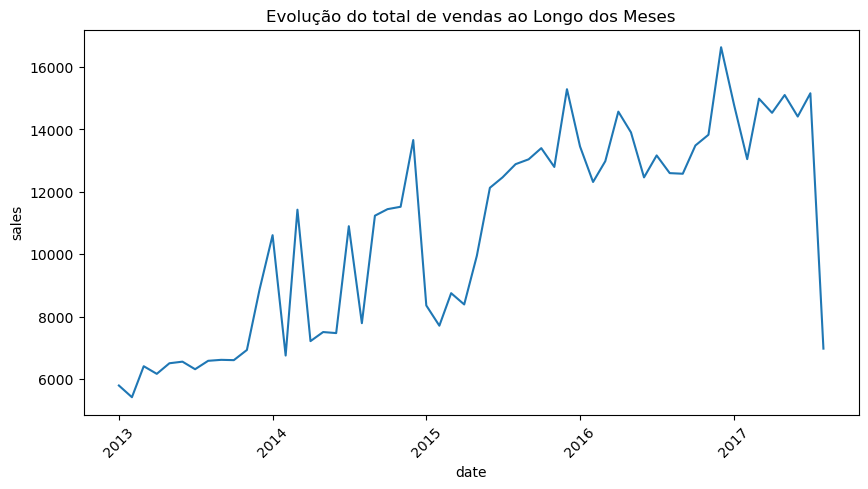

In [50]:
#ANÁLISE TEMPORAL - Evolução do Custo ao longo dos meses
df_grouped_mes = df.groupby('date')['sales'].mean().reset_index()
# Converter Period[M] para datetime (Timestamp)
df_grouped_mes['date'] = df_grouped_mes['date'].dt.to_timestamp()
# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_grouped_mes, x='date', y='sales')
plt.title('Evolução do total de vendas ao Longo dos Meses')
plt.xticks(rotation=45)
plt.show()

In [25]:
df.to_csv('1.dados_tratado.csv', index=False)